<a href="https://colab.research.google.com/github/Alisser2001/QuantumMachineLearning/blob/emmadev/OneClassSVMConcreteQML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

# URL del archivo raw en GitHub
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/concrete.dat"

# Descargar el contenido del archivo
response = requests.get(url)
lines = [line.strip() for line in response.text.splitlines()]

# Extraer atributos
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]

# Extraer datos (después de @data)
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]

# Crear DataFrame
df = pd.DataFrame(data, columns=attributes).astype(float)

print(df.head())


       Cement  BlastFurnaceSlag      FlyAsh       Water  Superplasticizer  \
0  252.000000               0.0    0.000000  185.000000               0.0   
1  295.799988               0.0    0.000000  185.699997               0.0   
2  252.300003               0.0   98.800003  146.300003              14.2   
3  172.399994              13.6  172.399994  156.800003               4.1   
4  162.000000             214.0  164.000000  202.000000              10.0   

   CoarseAggregate  FineAggregate   Age  ConcreteCompressiveStrength  
0      1111.000000     784.000000   7.0                    13.710000  
1      1091.400024     769.299988   7.0                    14.840000  
2       987.799988     889.000000   3.0                    21.780001  
3      1006.299988     856.400024  28.0                    33.689999  
4       820.000000     680.000000  28.0                    30.650000  


In [2]:
# =========================
# SETUP: paleta 'pastel' (nativa de seaborn) — sin guardado de imágenes
# =========================
import math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

palette_name = "pastel"
sns.set_theme(style="whitegrid", context="notebook", palette=palette_name, font_scale=1.05)
pal = sns.color_palette(palette_name)

# colores explícitos extraídos de la paleta
color_main  = pal[2]    # para histogramas / puntos
color_kde   = pal[1]    # para KDE / líneas suaves
color_accent= pal[-1]   # para líneas de regresión o destaque
box_color   = pal[0]    # para boxplots inset

print("Paleta aplicada:", palette_name, " — Colores:", pal)


Paleta aplicada: pastel  — Colores: [(0.6313725490196078, 0.788235294117647, 0.9568627450980393), (1.0, 0.7058823529411765, 0.5098039215686274), (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), (1.0, 0.6235294117647059, 0.6078431372549019), (0.8156862745098039, 0.7333333333333333, 1.0), (0.8705882352941177, 0.7333333333333333, 0.6078431372549019), (0.9803921568627451, 0.6901960784313725, 0.8941176470588236), (0.8117647058823529, 0.8117647058823529, 0.8117647058823529), (1.0, 0.996078431372549, 0.6392156862745098), (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]


In [3]:
# Vista rápida de los datos
print("Dimensiones:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nDescripción estadística:")
display(df.describe().T)

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nTipo de datos por columna:")
print(df.dtypes)

Dimensiones: (1030, 9)

Primeras filas:


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength
0,252.000000,0.0,0.000000,185.000000,0.0,1111.000000,784.000000,7.0,13.710000
1,295.799988,0.0,0.000000,185.699997,0.0,1091.400024,769.299988,7.0,14.840000
2,252.300003,0.0,98.800003,146.300003,14.2,987.799988,889.000000,3.0,21.780001
3,172.399994,13.6,172.399994,156.800003,4.1,1006.299988,856.400024,28.0,33.689999
4,162.000000,214.0,164.000000,202.000000,10.0,820.000000,680.000000,28.0,30.650000



Descripción estadística:


,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.000000,192.375000,272.899994,350.000000,540.000000
BlastFurnaceSlag,1030.0,73.895825,86.279341,0.000000,0.000000,22.000000,142.950001,359.399994
FlyAsh,1030.0,54.188350,63.997004,0.000000,0.000000,0.000000,118.300003,200.100006
Water,1030.0,181.567281,21.354218,121.800003,164.899994,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.204660,5.973841,0.000000,0.000000,6.400000,10.200000,32.200001
CoarseAggregate,1030.0,972.918932,77.753955,801.000000,932.000000,968.000000,1029.400024,1145.000000
FineAggregate,1030.0,773.580484,80.175980,594.000000,730.950012,779.500000,824.000000,992.599976
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
ConcreteCompressiveStrength,1030.0,35.817961,16.705742,2.330000,23.710001,34.445002,46.135001,82.599998



Valores nulos por columna:
Cement                         0
BlastFurnaceSlag               0
FlyAsh                         0
Water                          0
Superplasticizer               0
CoarseAggregate                0
FineAggregate                  0
Age                            0
ConcreteCompressiveStrength    0
dtype: int64

Tipo de datos por columna:
Cement                         float64
BlastFurnaceSlag               float64
FlyAsh                         float64
Water                          float64
Superplasticizer               float64
CoarseAggregate                float64
FineAggregate                  float64
Age                            float64
ConcreteCompressiveStrength    float64
dtype: object


confirmamos que no hay valores nulos y que todos son números, por lo tanto no es necesario pensar en una transformación ni en una imputación de datos

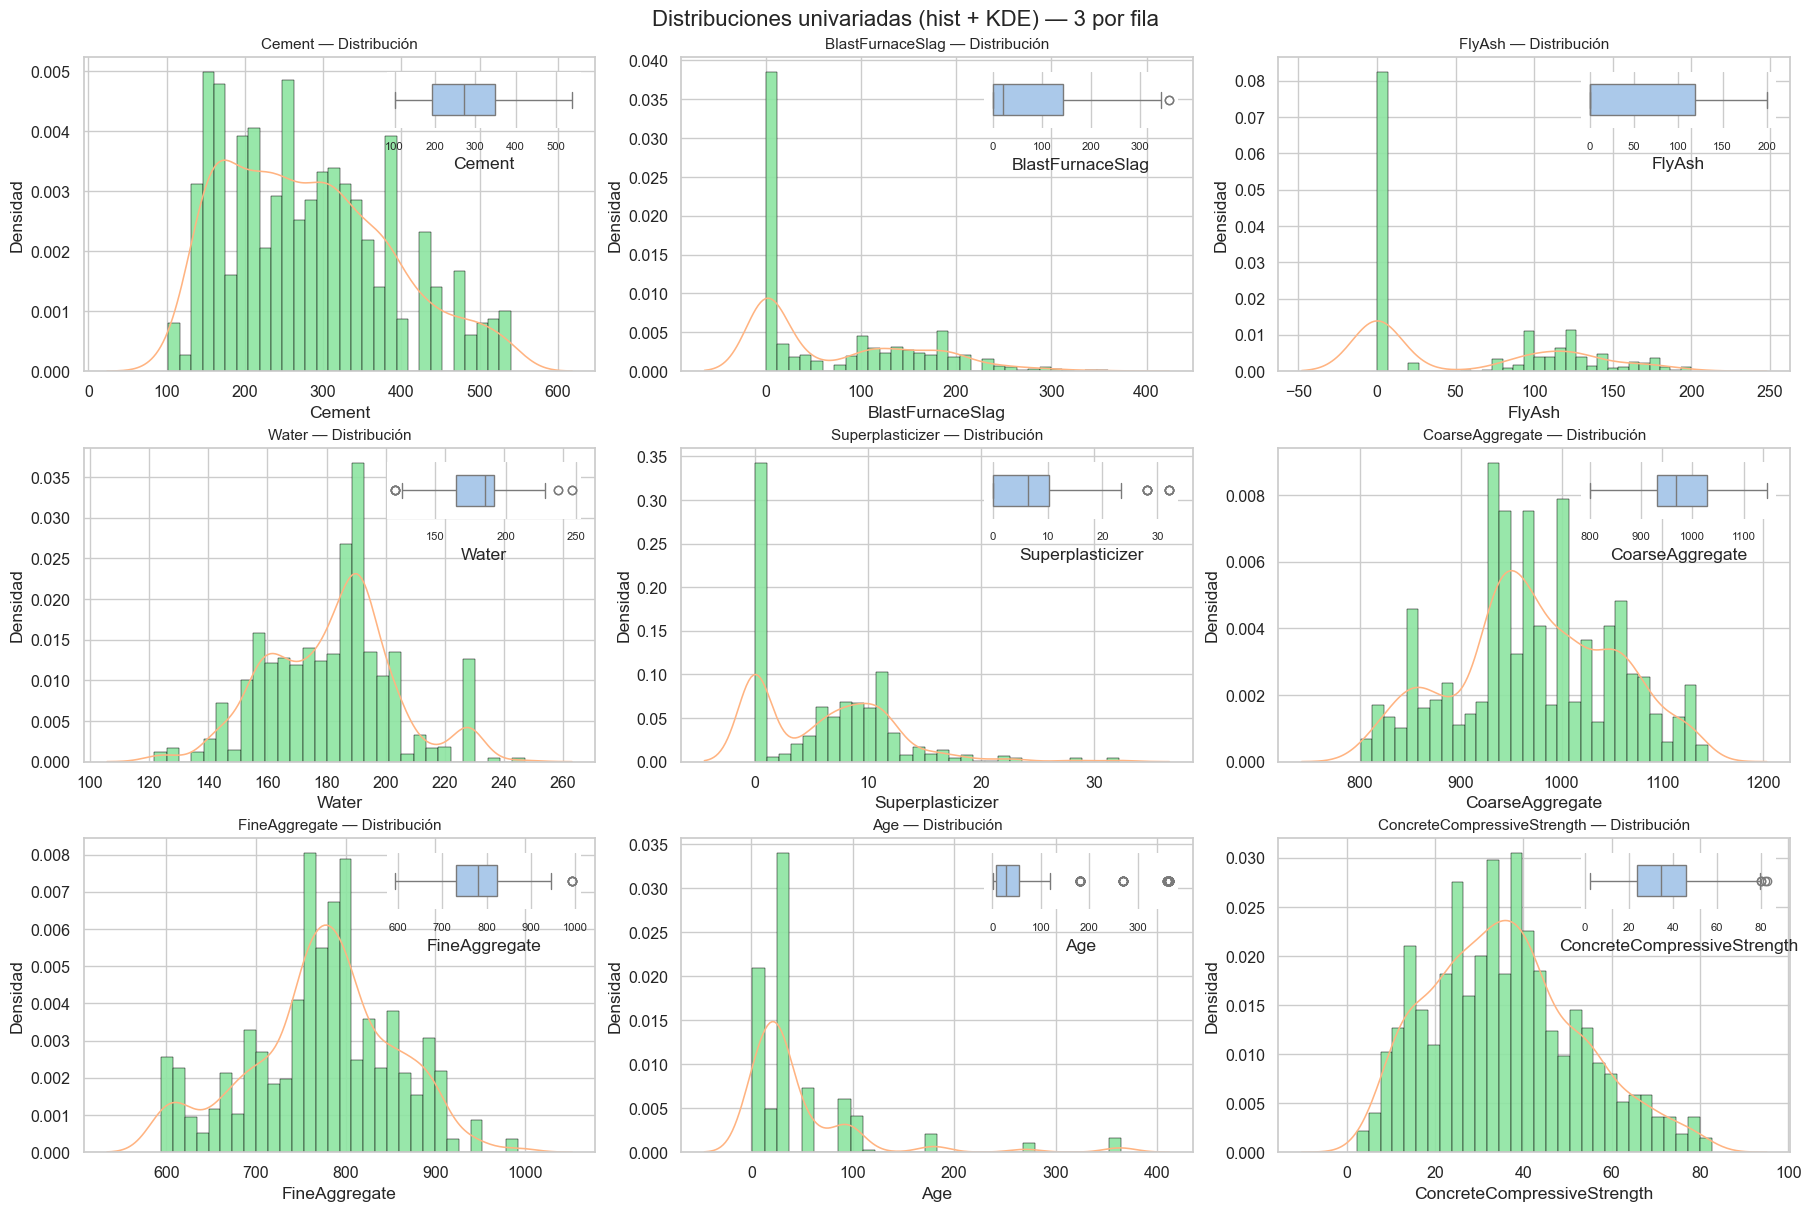

In [4]:
cols = df.columns.tolist()
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], kde=False, bins=30, ax=ax, stat="density",
                 color=color_main, edgecolor="black", linewidth=0.35, alpha=0.9)
    sns.kdeplot(df[col], ax=ax, color=color_kde, linewidth=1.15)
    ax.set_title(f"{col} — Distribución", fontsize=11)
    ax.set_ylabel("Densidad")

    axins = inset_axes(ax, width="38%", height="18%", loc='upper right', borderpad=0.9)
    sns.boxplot(x=df[col], ax=axins, orient="h", width=0.55, color=box_color)
    axins.set_yticks([])
    axins.tick_params(axis='both', which='both', labelsize=8)
    for spine in axins.spines.values():
        spine.set_visible(False)

for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])


fig.suptitle("Distribuciones univariadas (hist + KDE) — 3 por fila", fontsize=16)

plt.show()


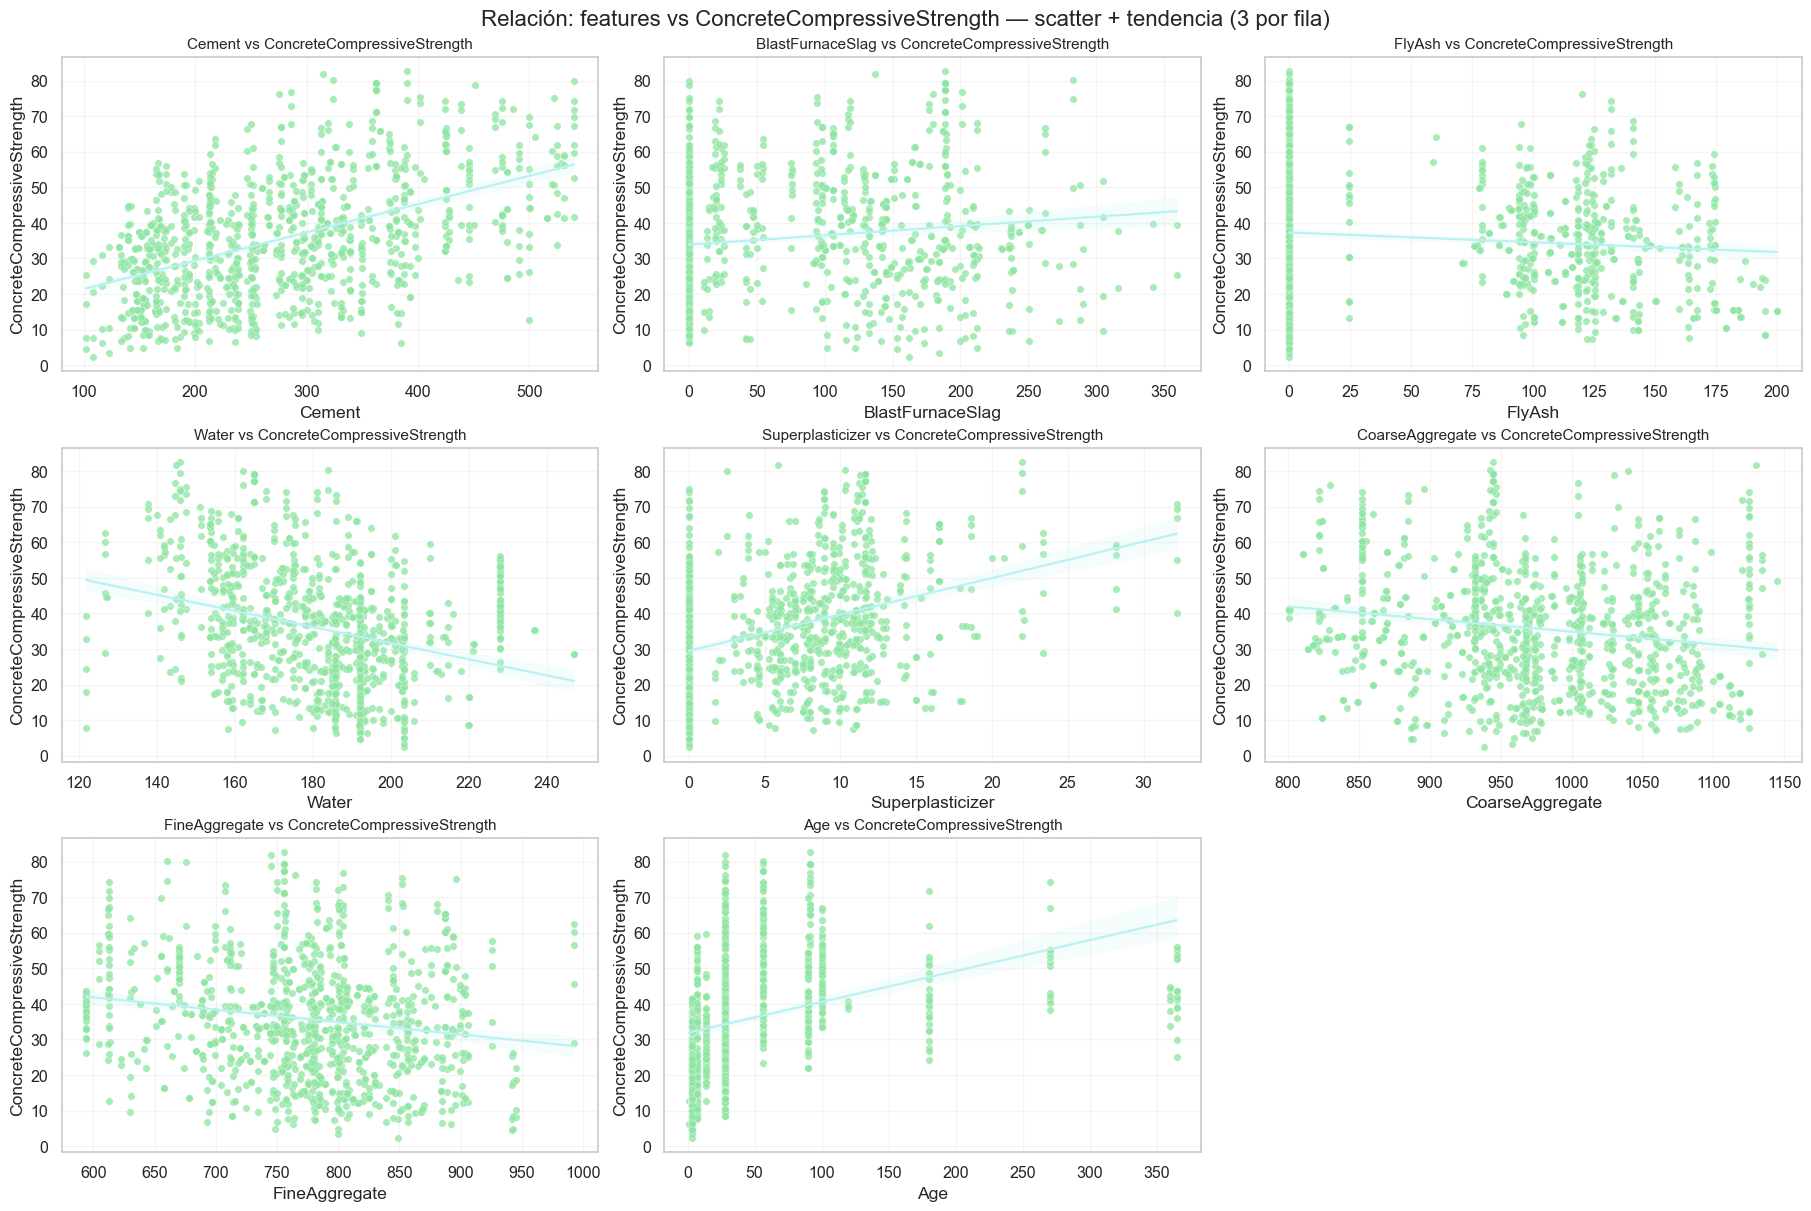

In [5]:
target = "ConcreteCompressiveStrength"
features = [c for c in df.columns if c != target]
n = len(features)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    sns.scatterplot(x=df[feat], y=df[target], ax=ax,
                    color=color_main, edgecolor="w", linewidth=0.25, s=28, alpha=0.75)
    sns.regplot(x=df[feat], y=df[target], scatter=False, ax=ax, truncate=True,
                line_kws={"linewidth":1.6, "color": color_accent})
    ax.set_title(f"{feat} vs {target}", fontsize=11)
    ax.set_xlabel(feat)
    ax.set_ylabel(target)
    ax.grid(alpha=0.2)

for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle(f"Relación: features vs {target} — scatter + tendencia (3 por fila)", fontsize=16)
plt.show()


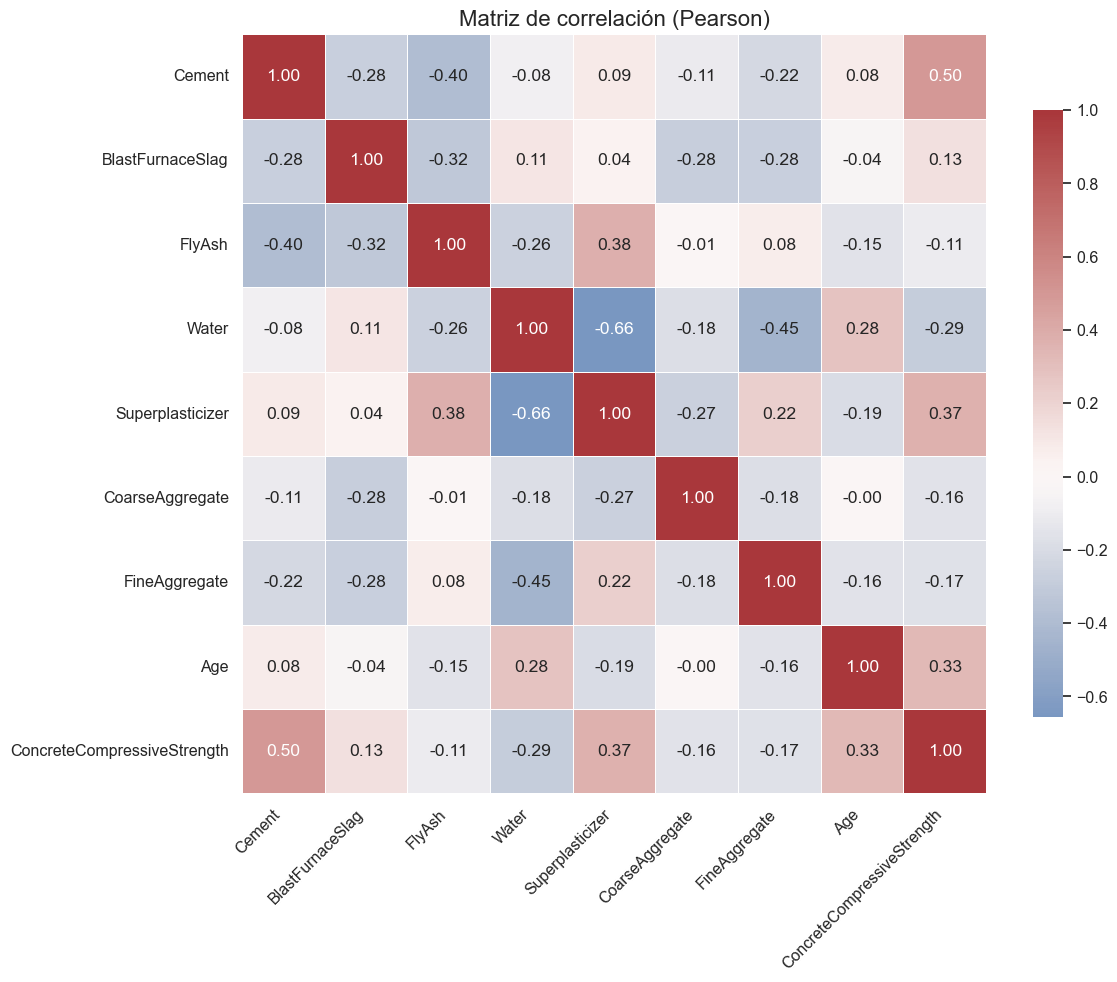


Correlación con la variable objetivo (orden descendente):


ConcreteCompressiveStrength    1.000000
Cement                         0.497832
Superplasticizer               0.366079
Age                            0.328873
BlastFurnaceSlag               0.134829
FlyAsh                        -0.105755
CoarseAggregate               -0.164935
FineAggregate                 -0.167241
Water                         -0.289633
Name: ConcreteCompressiveStrength, dtype: float64

In [6]:
corr = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=0.5, cbar_kws={"shrink":0.8})
plt.title("Matriz de correlación (Pearson)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCorrelación con la variable objetivo (orden descendente):")
display(corr[target].sort_values(ascending=False))





---



In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Escalar
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
ocsvm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05)  # 5% de outliers
y_pred = ocsvm.fit_predict(X_scaled)

df["ocsvm_outlier"] = (y_pred == -1)  # True si es outlier

print("=== Resumen OCSVM ===")
print(df["ocsvm_outlier"].value_counts())
print("\nMuestra de outliers detectados:")
display(df[df["ocsvm_outlier"]].head(10))


=== Resumen OCSVM ===
ocsvm_outlier
False    976
True      54
Name: count, dtype: int64

Muestra de outliers detectados:


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength,ocsvm_outlier
44,168.0,42.099998,163.800003,121.800003,5.700000,1058.699951,780.099976,3.0,7.750000,True
100,540.0,0.000000,0.000000,173.000000,0.000000,1125.000000,613.000000,270.0,74.169998,True
130,165.0,0.000000,143.600006,163.800003,0.000000,1005.599976,900.900024,3.0,14.400000,True
135,500.0,0.000000,0.000000,200.000000,0.000000,1125.000000,613.000000,270.0,55.160000,True
139,469.0,117.199997,0.000000,137.800003,32.200001,852.099976,840.500000,91.0,70.699997,True
154,469.0,117.199997,0.000000,137.800003,32.200001,852.099976,840.500000,3.0,40.200001,True
161,500.0,0.000000,0.000000,200.000000,0.000000,1125.000000,613.000000,1.0,12.640000,True
165,145.0,0.000000,179.000000,202.000000,8.000000,824.000000,869.000000,28.0,10.540000,True
196,491.0,26.000000,123.000000,201.000000,3.900000,822.000000,699.000000,3.0,29.549999,True
290,522.0,0.000000,0.000000,146.000000,0.000000,896.000000,896.000000,7.0,50.509998,True


In [9]:
import numpy as np
import pandas as pd
from itertools import product

nu_grid = [0.01, 0.03, 0.05, 0.1]
gamma_grid = ["scale", "auto", 0.1, 0.01]

results = []

for nu, gamma in product(nu_grid, gamma_grid):
    ocsvm = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
    y_pred = ocsvm.fit_predict(X_scaled)
    n_outliers = (y_pred == -1).sum()
    margin = ocsvm.decision_function(X_scaled).mean()

    results.append({
        "nu": nu,
        "gamma": gamma,
        "n_outliers": n_outliers,
        "mean_margin": margin
    })

df_ocsvm_grid = pd.DataFrame(results)
print("=== Resultados OneClassSVM ===")
display(df_ocsvm_grid)


=== Resultados OneClassSVM ===


,nu,gamma,n_outliers,mean_margin
0,0.01,scale,25,0.190534
1,0.01,auto,25,0.190534
2,0.01,0.1,23,0.272690
3,0.01,0.01,11,0.635286
4,0.03,scale,37,0.583744
5,0.03,auto,37,0.583744
6,0.03,0.1,34,0.839255
7,0.03,0.01,30,1.795889
8,0.05,scale,54,0.968019
9,0.05,auto,54,0.968019


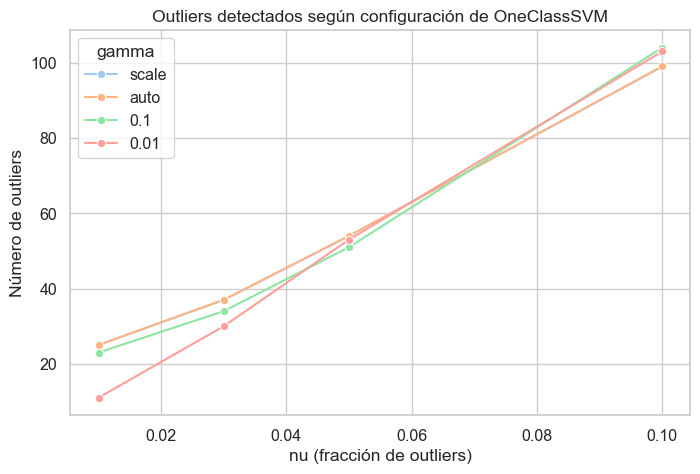

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.lineplot(data=df_ocsvm_grid, x="nu", y="n_outliers", hue="gamma", marker="o")
plt.title("Outliers detectados según configuración de OneClassSVM")
plt.ylabel("Número de outliers")
plt.xlabel("nu (fracción de outliers)")
plt.legend(title="gamma")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\3649082122.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="ocsvm_outlier", y=col, palette="pastel", ax=axes[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\3649082122.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="ocsvm_outlier", y=col, palette="pastel", ax=axes[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_10496\3649082122.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="ocsvm_outlier", y=col, palette="pastel", ax=axes[i])
C:\Users\Admi

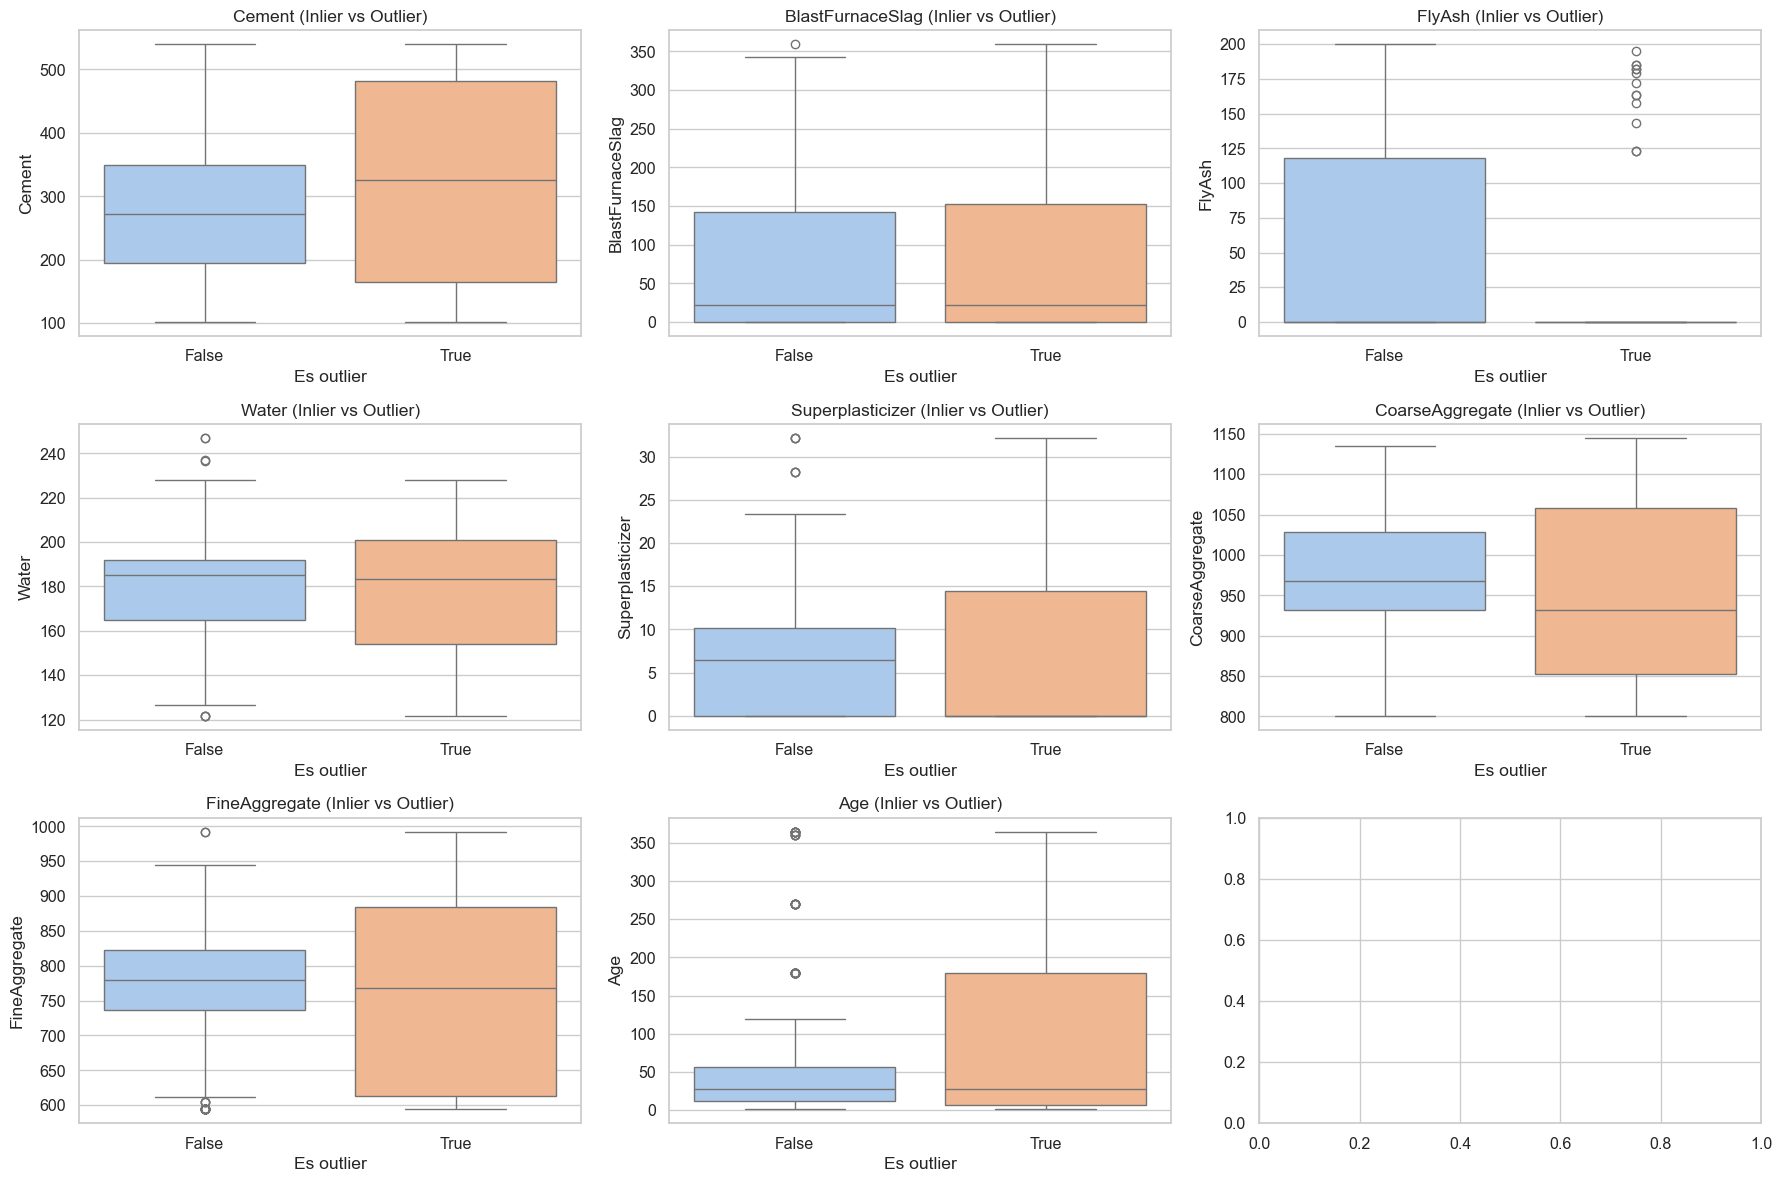

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(data=df, x="ocsvm_outlier", y=col, palette="pastel", ax=axes[i])
    axes[i].set_title(f"{col} (Inlier vs Outlier)")
    axes[i].set_xlabel("Es outlier")

plt.tight_layout()
plt.show()


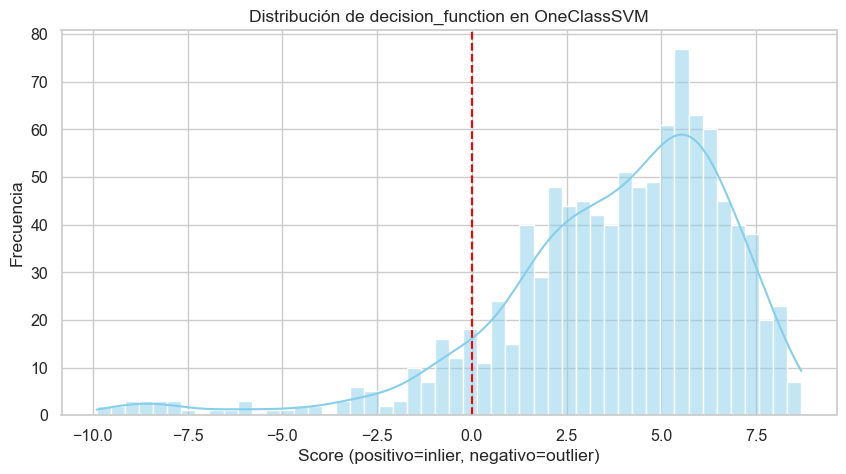

In [12]:
decision_scores = ocsvm.decision_function(X_scaled)

plt.figure(figsize=(10,5))
sns.histplot(decision_scores, bins=50, kde=True, color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribución de decision_function en OneClassSVM")
plt.xlabel("Score (positivo=inlier, negativo=outlier)")
plt.ylabel("Frecuencia")
plt.show()


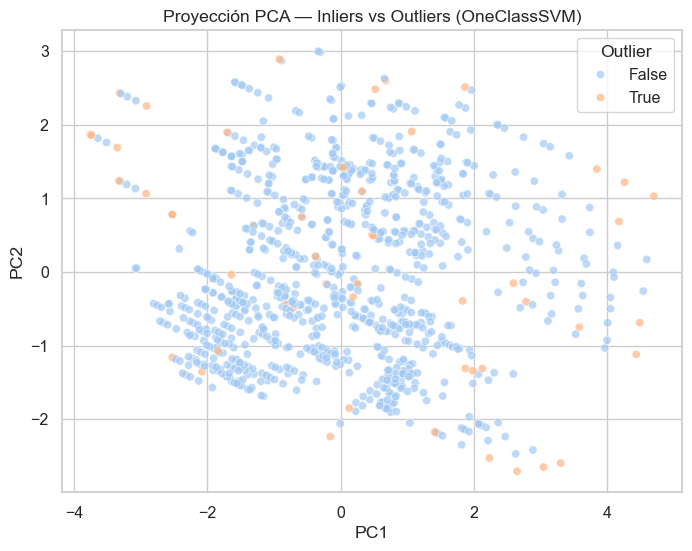

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df["ocsvm_outlier"], palette="pastel", alpha=0.7)
plt.title("Proyección PCA — Inliers vs Outliers (OneClassSVM)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Outlier")
plt.show()


In [14]:
# Nos quedamos solo con los inliers
df_clean = df[df["ocsvm_outlier"] == False].copy()

print("Original:", df.shape)
print("Limpio:", df_clean.shape)


Original: (1030, 10)
Limpio: (976, 10)


In [15]:
df_clean.to_csv("concrete_cleanOCSVM.csv", index=False)